# Summary

Starting point for a supervised learning model for Ookla speed tiles. The data comes from a combination of 
Ookla Open Data speed tests and Statistics Canada information, including 2016 census population data and census boundaries (shapefiles). 


In [3]:
import sys
sys.path.append("..")

In [4]:
import src.config

In [5]:
from src.datasets.loading import statcan, ookla

In [6]:
import numpy as np 
import pandas as pd
import geopandas as gp

In [7]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics

In [32]:
import matplotlib.pyplot as plt 
import plotly.express as px

## Load 
Load some of the available data. The census population data and StatCan boundaries are automatically loaded from 
the StatCan website. The overlays and tile geometries/speeds need to pre-computed and saved to the overlays directory and data directories. 

### Load All Unique Tile Gemoetries

In [9]:
ookla_tiles = ookla.canada_tiles()

### Load Census Population Information

In [10]:
da_pops = statcan.dissemination_areas_populations()

/home/jovyan/src/datasets/loading/statcan.py:234: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


### Labelling Tiles
Generate labels from geometric overlay of the Ookla tiles and Statistics Canada Dissemination Areas (DA). 
Label each tile with the information from the StatCan areas based on which DA the tile overlaps the most with.

In [11]:
o = gp.read_file(src.config.OVERLAYS_DIR / 'tile_das_overlay') #this can take a few minutes to load.
tile_da_label = o.dropna(subset=['DAUID','quadkey']).sort_values(by=['quadkey','tile_frac'],ascending=False).drop_duplicates(subset='quadkey', keep='first')
tile_da_label['quadkey'] = tile_da_label['quadkey'].astype(int)
tile_da_label['DAUID'] = tile_da_label['DAUID'].astype(int)

### Speed Test Data
Load in the previous 4 quarters of data. Since we're currently in Q3 of 2022, the most recent quarter is Q2 
so we can slice the files listed to grab those. Subsequently, we'll calculate weighted averages for individual tiles and use those as representative speeds for our model.

In [12]:
last_4_quarters = ookla.speed_data(ookla.available_files().loc[('fixed',2021,3):('fixed',2022,2)].path)

In [13]:
down = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_d_kbps, weights=s.tests)).rename('avg_d_kbps')
up = last_4_quarters.groupby('quadkey').apply(lambda s:np.average(s.avg_u_kbps, weights=s.tests)).rename('avg_u_kbps')
tests = last_4_quarters.groupby('quadkey')['tests'].sum()
devices = last_4_quarters.groupby('quadkey')['devices'].sum()
last4_agg = pd.concat([down, up, tests, devices],axis=1)

### Merge All The Data
It's a bit messy, but we're merging several tables and removing a few of the redundant or non-useful 
columns as we go through. At the end the `features_table` variable will have all of the 
tiles within census areas labelled by what type of Census Subdivision, Dissemination Area, Population Centre, etc. they are in, as well as population information for the DA (smallest area with populations available) and the speed test averages over the last 4 quarters.

In [14]:
## merge dissemination area (DA) populations with ookla tiles (already combined with other statcan data)
features_table = tile_da_label.merge(da_pops, on='DAUID', how='left')
features_table['DAPOP'] = features_table['DAPOP'].fillna(0).astype(int)
del features_table['GEO_NAME']
features_table = pd.DataFrame(features_table)
del features_table['geometry']
features_table['POP_DENSITY'] = features_table['DAPOP']/features_table['das_area']*1000**2 #people per square kilometer

# take all ookla tiles, merge the speeds data and tile labels and populations
features_table = ookla_tiles.merge(last4_agg, on='quadkey').merge(features_table, on='quadkey')

# compute spatial joins to identify if area is a population centre
pop_info = statcan.boundary('population_centres').to_crs('epsg:4326')
pop_info = pop_info[['PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS', 'geometry']] ##removes some redundant cols from DAs
features_table = features_table.sjoin(pop_info, how='left')
del features_table['index_right']
features_table = features_table.sort_values(by=['PCUID','quadkey']).drop_duplicates(subset=['quadkey']) #keep tiles where overlap was true

### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [15]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [16]:
col_subset = [pkey] + categorical_labels + numerical_vars + target_vars
features_table.loc[:,col_subset].set_index('quadkey')

,PRNAME,CDTYPE,CSDTYPE,SACTYPE,CMATYPE,PCTYPE,PCCLASS,tests,devices,das_area,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,avg_d_kbps,avg_u_kbps
quadkey,,,,,,,,,,,,,,,,,
302231302213222,Ontario,RM,T,1,B,2,2,12,8,4.489387e+06,205331.876525,0.917314,0.041955,1420,316.301553,201908.916667,23286.833333
302231302230013,Ontario,RM,T,1,B,2,2,32,7,5.391016e+06,205402.379648,0.894827,0.034094,1030,191.058601,393118.031250,169457.281250
302231302230022,Ontario,RM,T,1,B,2,2,4,2,1.030375e+07,205472.906899,0.611219,0.012189,505,49.011263,19284.750000,4310.750000
302231302230023,Ontario,RM,T,1,B,2,2,128,13,1.765704e+06,205472.906900,0.871430,0.101407,795,450.245236,10499.585938,1387.898438
302231302230030,Ontario,RM,T,1,B,2,2,1,1,5.391016e+06,205437.640257,0.939933,0.035818,1030,191.058601,535.000000,889.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303303002030011,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,NaN,NaN,NaN,1,1,1.777728e+07,179010.291685,0.579748,0.005838,350,19.688054,43155.000000,1901.000000
303303002032102,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,5,NaN,NaN,NaN,1,1,1.777728e+07,179287.191779,0.533632,0.005382,350,19.688054,1634.000000,690.000000
303303002122000,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,7,NaN,NaN,NaN,1,1,1.194131e+06,179256.404038,0.574792,0.086285,150,125.614323,37799.000000,12489.000000


In [17]:
print(features_table.dtypes)

quadkey           int64
geometry       geometry
avg_d_kbps      float64
avg_u_kbps      float64
tests             int64
devices           int64
DAUID             int64
PRUID            object
PRNAME           object
CDUID            object
CDNAME           object
CDTYPE           object
CCSUID           object
CCSNAME          object
CSDUID           object
CSDNAME          object
CSDTYPE          object
ERUID            object
ERNAME           object
SACCODE          object
SACTYPE          object
CMAUID           object
CMAPUID          object
CMANAME          object
CMATYPE          object
CTUID            object
CTNAME           object
ADAUID           object
das_area        float64
tile_area       float64
tile_frac       float64
das_frac        float64
DAPOP             int64
POP_DENSITY     float64
PCUID            object
PCNAME           object
PCTYPE           object
PCPUID           object
PCCLASS          object
dtype: object


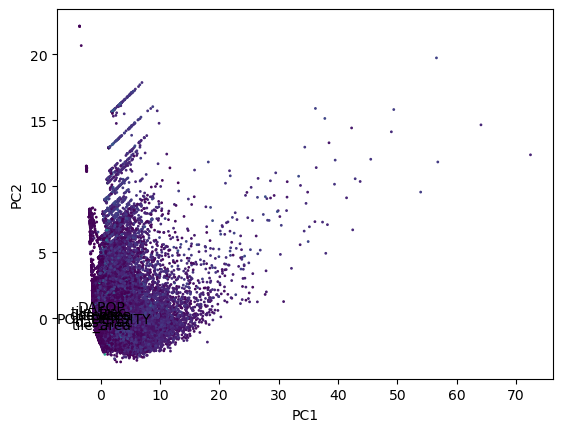

Explained variance ratios: [0.41635673 0.14240979]


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

y_up = features_table["avg_u_kbps"] 
x = features_table.loc[:, numerical_vars]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components = 2)

x_pca = pca.fit_transform(x_scaled)
original_variables_pca = pca.transform(x_scaled)

# Create a scatter plot of the PCA data with original variables
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_up, cmap='viridis', s = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add the original variables to the scatter plot
for i, variable in enumerate(x.columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='black', alpha=0.5)
    plt.text(pca.components_[0, i] * 1.2, pca.components_[1, i] * 1.2, variable, color='black', ha='center', va='center')

plt.show()
explained_variance_ratios = pca.explained_variance_ratio_
print('Explained variance ratios:', explained_variance_ratios)

In [19]:
features_table

,quadkey,geometry,avg_d_kbps,avg_u_kbps,tests,devices,DAUID,PRUID,PRNAME,CDUID,...,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,PCUID,PCNAME,PCTYPE,PCPUID,PCCLASS
32915,302231302213222,"POLYGON ((-80.02441 43.64800, -80.01892 43.648...",201908.916667,23286.833333,12,8,35240570,35,Ontario,3524,...,205331.876525,0.917314,0.041955,1420,316.301553,0001,Acton,2,350001,2
67352,302231302230013,"POLYGON ((-80.05188 43.64005, -80.04639 43.640...",393118.031250,169457.281250,32,7,35240571,35,Ontario,3524,...,205402.379648,0.894827,0.034094,1030,191.058601,0001,Acton,2,350001,2
185959,302231302230022,"POLYGON ((-80.06836 43.63210, -80.06287 43.632...",19284.750000,4310.750000,4,2,35240629,35,Ontario,3524,...,205472.906899,0.611219,0.012189,505,49.011263,0001,Acton,2,350001,2
38693,302231302230023,"POLYGON ((-80.06287 43.63210, -80.05737 43.632...",10499.585938,1387.898438,128,13,35240573,35,Ontario,3524,...,205472.906900,0.871430,0.101407,795,450.245236,0001,Acton,2,350001,2
52422,302231302230030,"POLYGON ((-80.05737 43.63608, -80.05188 43.636...",535.000000,889.000000,1,1,35240571,35,Ontario,3524,...,205437.640257,0.939933,0.035818,1030,191.058601,0001,Acton,2,350001,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283489,303303002030011,"POLYGON ((-53.33313 46.73986, -53.32764 46.739...",43155.000000,1901.000000,1,1,10010735,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179010.291685,0.579748,0.005838,350,19.688054,NaN,NaN,NaN,NaN,NaN
258525,303303002032102,"POLYGON ((-53.32764 46.70597, -53.32214 46.705...",1634.000000,690.000000,1,1,10010735,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179287.191779,0.533632,0.005382,350,19.688054,NaN,NaN,NaN,NaN,NaN
214589,303303002122000,"POLYGON ((-53.26172 46.70974, -53.25623 46.709...",37799.000000,12489.000000,1,1,10010734,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179256.404038,0.574792,0.086285,150,125.614323,NaN,NaN,NaN,NaN,NaN
285249,303303002122001,"POLYGON ((-53.25623 46.70974, -53.25073 46.709...",40291.272727,9116.000000,11,3,10010734,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,...,179256.404038,1.000000,0.150114,150,125.614323,NaN,NaN,NaN,NaN,NaN


# Clustering for Census Divisions and Census Subdivision Types. 


In [20]:
features_table.columns

Index(['quadkey', 'geometry', 'avg_d_kbps', 'avg_u_kbps', 'tests', 'devices',
       'DAUID', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME', 'CDTYPE', 'CCSUID',
       'CCSNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'ERUID', 'ERNAME', 'SACCODE',
       'SACTYPE', 'CMAUID', 'CMAPUID', 'CMANAME', 'CMATYPE', 'CTUID', 'CTNAME',
       'ADAUID', 'das_area', 'tile_area', 'tile_frac', 'das_frac', 'DAPOP',
       'POP_DENSITY', 'PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS'],
      dtype='object')

In [21]:
cluster_features = ['CDTYPE', 'CSDTYPE']
cluster_data = features_table[cluster_features + target_vars]
cluster_data = cluster_data.sample(n=10000)  # fit using a random subset of data to save time

In [22]:
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV


# clustering = OPTICS(min_samples=50, xi=0.01, metric='euclidean')
clustering = KMeans(n_clusters=4)

colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in set(categorical_labels) & set(cluster_features)] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in set(numerical_vars) & set(cluster_features)] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)
clustering_pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('clustering', clustering)
])

clustering_pipe.fit(cluster_data)

labels = clustering.labels_

print(labels)



[1 0 2 ... 1 1 0]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Using GridSearchCV to find optimal values:

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

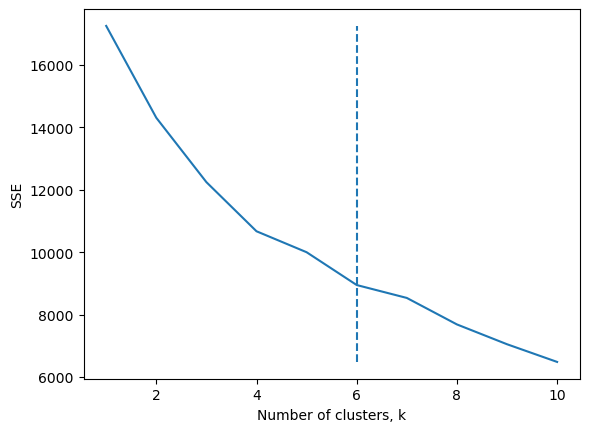

NameError: name 'optimal_k' is not defined

In [28]:
# KMeans Elbow-method
colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in set(categorical_labels) & set(cluster_features)] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in set(numerical_vars) & set(cluster_features)] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)

sse = {}
for k in range(1, 11):
    clustering = KMeans(n_clusters=k)


    clustering_pipe = pipeline.Pipeline([
        ('preprocess',colTransformer),
        ('clustering', clustering)
    ])
    clustering_pipe.fit(cluster_data)

    sse[k] = clustering.inertia_


# plot SSE vs. k with elbow point
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters, k')
plt.ylabel('SSE')
plt.vlines(6, ymin=min(sse.values()), ymax=max(sse.values()), linestyle='--') 
plt.show()



6 was found to be a good value while using a subset of the data

In [30]:
clustering = KMeans(n_clusters=6)

colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in set(categorical_labels) & set(cluster_features)] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in set(numerical_vars) & set(cluster_features)] 
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)
clustering_pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('clustering', clustering)
])

clustering_pipe.fit(cluster_data)

labels = clustering.labels_

cluster_data['kmeans_cluster_label'] = labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
def scatter_3d(df, x:str='CDTYPE', y:str='CSDTYPE', z:str='avg_d_kbps', color:str='kmeans_cluster_label'):
    fig = px.scatter_3d(df, x=x, y=y, z=z, color=color)
    fig.show()

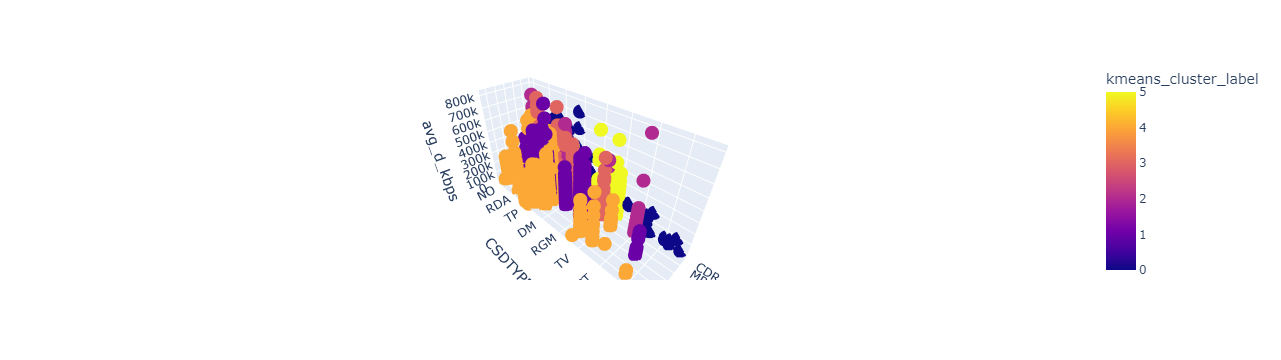

In [36]:
# cluster_data

scatter_3d(cluster_data, x='CDTYPE', y='CSDTYPE', z='avg_d_kbps', color='kmeans_cluster_label')

In [37]:
#OPTICS

params = {'min_samples': range(2, 10), 'xi': np.linspace(0.01, 0.1, num=10)}

# create an OPTICS object
clustering = OPTICS()

# create a pipeline with a preprocessing step and the OPTICS clustering step
pipe = pipeline.Pipeline([
    ('preprocess', colTransformer), # add a StandardScaler preprocessing step
    ('clustering', clustering)
])

# perform a grid search to find the best values for min_samples and xi
grid_search = GridSearchCV(pipe, param_grid=params, scoring='silhouette')
grid_search.fit(cluster_data)

# print the best values of min_samples and xi
print(grid_search.best_params_)

ValueError: 'silhouette' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [ ]:
# Initialize lists to store the metric scores and hyperparameters
silhouette_scores = []
params = []

# Loop over all combinations of hyperparameters
for min_samples in min_samples_range:
    print(min_samples)
    for xi in xi_range:
        #print("xi is: ", xi)
        for min_cluster_size in min_cluster_size_range:
            #print("min_cluster_size is: ", min_cluster_size)
            # Create OPTICS object
            optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
            # Fit the model
            optics.fit(df)
            # Get cluster labels
            labels = optics.labels_
            # Compute the silhouette score
            if (len(set(labels)) > 1 and len(set(labels)) <145):
                score = silhouette_score(df, labels)
                # Store the score and hyperparameters
                silhouette_scores.append(score)
                params.append((min_samples, xi, min_cluster_size))

# Convert the lists to numpy arrays
silhouette_scores = np.array(silhouette_scores)
params = np.array(params)

# Find the hyperparameters that give the best silhouette score
best_params = params[np.argmax(silhouette_scores)]
best_score = np.max(silhouette_scores)

# Plot the results
fig, ax = plt.subplots()
ax.scatter(params[:, 0], params[:, 1], c=silhouette_scores)
ax.set_xlabel('min_samples')
ax.set_ylabel('xi')
#ax.set_zlabel('min_cluster_size')
plt.show()

print('Best hyperparameters:', best_params)
print('Best silhouette score:', best_score)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f789f4e19f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f789f4e27a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f789f4e17b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f789f4e3040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f789f4e3430>],
 'means': []}

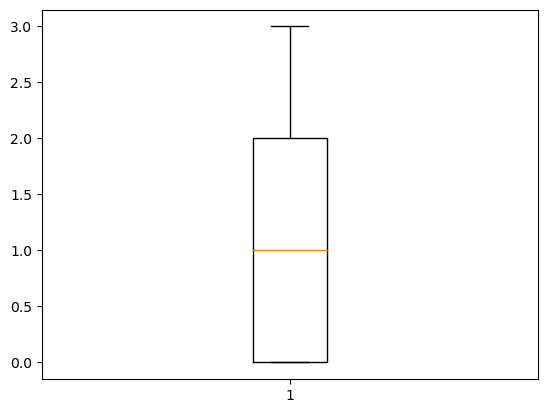

In [59]:
plt.boxplot(labels)


In [60]:
counts = {}

# Loop through the list and count the occurrences of each element
for l in labels:
    counts[l] = list(labels).count(l)

# Print the dictionary
print(counts)

{0: 2737, 3: 1914, 2: 2032, 1: 3317}
